Take the sos netcdfs, add a bunch of useful variables, save as a tidy dataset.

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import datetime as dt

from sublimpy import variables
from sublimpy import utils
from sublimpy import tidy

import matplotlib.pyplot as plt

import altair as alt
alt.data_transformers.enable('json')

from metpy.calc import specific_humidity_from_mixing_ratio
from metpy.units import units
import metpy.constants
import pint_pandas
import pint_xarray
import xarray as xr

# Inputs

In [2]:
sos_data_dir = '/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_qc_geo_tiltcor_v20240213/'
DATE_FORMAT_STR = '%Y%m%d'
# start_date = '20221201'
# end_date = dt.datetime.strftime(dt.date.today() - dt.timedelta(days=1), DATE_FORMAT_STR)
start_date = '20221130'
end_date = '20230509'
PLANAR_FIT = False

datelist = pd.date_range(
    dt.datetime.strptime(start_date, DATE_FORMAT_STR),
    dt.datetime.strptime(end_date, DATE_FORMAT_STR),
    freq='d'
).strftime(DATE_FORMAT_STR).tolist()

VARIABLE_NAMES = [
    # Sonic Anemometer Data for 4 towers
    'h2o_1m_uw' ,'tc_1m_uw',     'spd_1m_uw',     'dir_1m_uw',     'u_1m_uw',   'v_1m_uw',   'w_1m_uw',   'u_u__1m_uw',    'v_v__1m_uw',    'w_w__1m_uw',    
        'u_w__1m_uw',    'v_w__1m_uw',  'u_tc__1m_uw',  'v_tc__1m_uw',   'u_h2o__1m_uw',  'v_h2o__1m_uw',   'w_tc__1m_uw',   'w_h2o__1m_uw',
    'h2o_3m_uw' ,'tc_3m_uw',     'spd_3m_uw',     'dir_3m_uw',     'u_3m_uw',   'v_3m_uw',   'w_3m_uw',   'u_u__3m_uw',    'v_v__3m_uw',    'w_w__3m_uw',    
        'u_w__3m_uw',    'v_w__3m_uw',  'u_tc__3m_uw',  'v_tc__3m_uw',   'u_h2o__3m_uw',  'v_h2o__3m_uw',   'w_tc__3m_uw',   'w_h2o__3m_uw',
    'h2o_10m_uw' ,'tc_10m_uw',    'spd_10m_uw',    'dir_10m_uw',    'u_10m_uw',  'v_10m_uw',  'w_10m_uw',  'u_u__10m_uw',   'v_v__10m_uw',   'w_w__10m_uw',   
        'u_w__10m_uw',   'v_w__10m_uw', 'u_tc__10m_uw', 'v_tc__10m_uw',  'u_h2o__10m_uw', 'v_h2o__10m_uw',  'w_tc__10m_uw',  'w_h2o__10m_uw',

    'h2o_1m_ue' ,'tc_1m_ue',     'spd_1m_ue',     'dir_1m_ue',     'u_1m_ue',   'v_1m_ue',   'w_1m_ue',   'u_u__1m_ue',    'v_v__1m_ue',    'w_w__1m_ue',    
        'u_w__1m_ue',    'v_w__1m_ue',  'u_tc__1m_ue',  'v_tc__1m_ue',   'u_h2o__1m_ue',  'v_h2o__1m_ue',   'w_tc__1m_ue',   'w_h2o__1m_ue',
    'h2o_3m_ue' ,'tc_3m_ue',     'spd_3m_ue',     'dir_3m_ue',     'u_3m_ue',   'v_3m_ue',   'w_3m_ue',   'u_u__3m_ue',    'v_v__3m_ue',    'w_w__3m_ue',    
        'u_w__3m_ue',    'v_w__3m_ue',  'u_tc__3m_ue',  'v_tc__3m_ue',   'u_h2o__3m_ue',  'v_h2o__3m_ue',   'w_tc__3m_ue',   'w_h2o__3m_ue',
    'h2o_10m_ue' ,'tc_10m_ue',    'spd_10m_ue',    'dir_10m_ue',    'u_10m_ue',  'v_10m_ue',  'w_10m_ue',  'u_u__10m_ue',   'v_v__10m_ue',   'w_w__10m_ue',   
        'u_w__10m_ue',   'v_w__10m_ue', 'u_tc__10m_ue', 'v_tc__10m_ue',  'u_h2o__10m_ue', 'v_h2o__10m_ue',  'w_tc__10m_ue',  'w_h2o__10m_ue',

    'h2o_1m_d' ,'tc_1m_d',      'spd_1m_d',     'dir_1m_d',     'u_1m_d',   'v_1m_d',   'w_1m_d',   'u_u__1m_d',    'v_v__1m_d',    'w_w__1m_d',    
        'u_w__1m_d',    'v_w__1m_d',  'u_tc__1m_d',  'v_tc__1m_d',   'u_h2o__1m_d',  'v_h2o__1m_d',   'w_tc__1m_d',   'w_h2o__1m_d',
    'h2o_3m_d' ,'tc_3m_d',      'spd_3m_d',     'dir_3m_d',     'u_3m_d',   'v_3m_d',   'w_3m_d',   'u_u__3m_d',    'v_v__3m_d',    'w_w__3m_d',    
        'u_w__3m_d',    'v_w__3m_d',  'u_tc__3m_d',  'v_tc__3m_d',   'u_h2o__3m_d',  'v_h2o__3m_d',   'w_tc__3m_d',   'w_h2o__3m_d',
    'h2o_10m_d' ,'tc_10m_d',     'spd_10m_d',    'dir_10m_d',    'u_10m_d',  'v_10m_d',  'w_10m_d',  'u_u__10m_d',   'v_v__10m_d',   'w_w__10m_d',   
        'u_w__10m_d',   'v_w__10m_d', 'u_tc__10m_d', 'v_tc__10m_d',  'u_h2o__10m_d', 'v_h2o__10m_d',  'w_tc__10m_d',  'w_h2o__10m_d',

    'h2o_1m_c' ,'tc_1m_c',  'spd_1m_c',     'dir_1m_c',     'u_1m_c',   'v_1m_c',   'w_1m_c',   'u_u__1m_c',    'v_v__1m_c',    'w_w__1m_c',    
        'u_w__1m_c',    'v_w__1m_c',  'u_tc__1m_c',  'v_tc__1m_c',   'u_h2o__1m_c',  'v_h2o__1m_c',   'w_tc__1m_c',   'w_h2o__1m_c',
    'h2o_2m_c' ,'tc_2m_c',  'spd_2m_c',     'dir_2m_c',     'u_2m_c',   'v_2m_c',   'w_2m_c',   'u_u__2m_c',    'v_v__2m_c',    'w_w__2m_c',    
        'u_w__2m_c',    'v_w__2m_c',  'u_tc__2m_c',  'v_tc__2m_c',   'u_h2o__2m_c',  'v_h2o__2m_c',   'w_tc__2m_c',   'w_h2o__2m_c',
    'h2o_3m_c' ,'tc_3m_c',  'spd_3m_c',     'dir_3m_c',     'u_3m_c',   'v_3m_c',   'w_3m_c',   'u_u__3m_c',    'v_v__3m_c',    'w_w__3m_c',    
        'u_w__3m_c',    'v_w__3m_c',  'u_tc__3m_c',  'v_tc__3m_c',   'u_h2o__3m_c',  'v_h2o__3m_c',   'w_tc__3m_c',   'w_h2o__3m_c',
    'h2o_5m_c' ,'tc_5m_c',  'spd_5m_c',     'dir_5m_c',     'u_5m_c',   'v_5m_c',   'w_5m_c',   'u_u__5m_c',    'v_v__5m_c',    'w_w__5m_c',    
        'u_w__5m_c',    'v_w__5m_c',  'u_tc__5m_c',  'v_tc__5m_c',   'u_h2o__5m_c',  'v_h2o__5m_c',   'w_tc__5m_c',   'w_h2o__5m_c',
    'h2o_10m_c' ,'tc_10m_c', 'spd_10m_c',    'dir_10m_c',    'u_10m_c',  'v_10m_c',  'w_10m_c',  'u_u__10m_c',   'v_v__10m_c',   'w_w__10m_c',   
        'u_w__10m_c',   'v_w__10m_c', 'u_tc__10m_c', 'v_tc__10m_c',  'u_h2o__10m_c', 'v_h2o__10m_c',  'w_tc__10m_c',  'w_h2o__10m_c',
    'h2o_15m_c' ,'tc_15m_c', 'spd_15m_c',    'dir_15m_c',    'u_15m_c',  'v_15m_c',  'w_15m_c',  'u_u__15m_c',   'v_v__15m_c',   'w_w__15m_c',   
        'u_w__15m_c',   'v_w__15m_c', 'u_tc__15m_c', 'v_tc__15m_c',  'u_h2o__15m_c', 'v_h2o__15m_c',  'w_tc__15m_c',  'w_h2o__15m_c',
    'h2o_20m_c' ,'tc_20m_c', 'spd_20m_c',    'dir_20m_c',    'u_20m_c',  'v_20m_c',  'w_20m_c',  'u_u__20m_c',   'v_v__20m_c',   'w_w__20m_c',   
        'u_w__20m_c',   'v_w__20m_c', 'u_tc__20m_c', 'v_tc__20m_c',  'u_h2o__20m_c', 'v_h2o__20m_c',  'w_tc__20m_c',  'w_h2o__20m_c',

    
    # Temperature & Relative Humidity Array 
    'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c', 'T_6m_c', 'T_7m_c', 'T_8m_c', 'T_9m_c', 'T_10m_c',
    'T_11m_c', 'T_12m_c', 'T_13m_c', 'T_14m_c', 'T_15m_c', 'T_16m_c', 'T_17m_c', 'T_18m_c', 'T_19m_c', 'T_20m_c',

    'RH_2m_c', 'RH_3m_c', 'RH_4m_c', 'RH_5m_c', 'RH_6m_c', 'RH_7m_c', 'RH_8m_c', 'RH_9m_c', 'RH_10m_c',
    'RH_11m_c','RH_12m_c','RH_13m_c','RH_14m_c','RH_15m_c','RH_16m_c','RH_17m_c','RH_18m_c','RH_19m_c','RH_20m_c',

    # Pressure Sensors
    'P_20m_c',
    'P_10m_c', 'P_10m_d', 'P_10m_uw', 'P_10m_ue',

    # Blowing snow/FlowCapt Sensors
    'SF_avg_1m_ue', 'SF_avg_2m_ue',

    # Apogee sensors
    "Vtherm_c", "Vtherm_d", "Vtherm_ue", "Vtherm_uw", 
    "Vpile_c", "Vpile_d", "Vpile_ue", "Vpile_uw",
    "IDir_c", "IDir_d", "IDir_ue", "IDir_uw",

    # Snow-level temperature arrays (towers D and UW)
    'Tsnow_0_4m_d', 'Tsnow_0_5m_d', 'Tsnow_0_6m_d', 'Tsnow_0_7m_d', 'Tsnow_0_8m_d', 'Tsnow_0_9m_d', 'Tsnow_1_0m_d', 'Tsnow_1_1m_d', 'Tsnow_1_2m_d', 'Tsnow_1_3m_d', 'Tsnow_1_4m_d', 'Tsnow_1_5m_d',
    'Tsnow_0_4m_uw', 'Tsnow_0_5m_uw', 'Tsnow_0_6m_uw', 'Tsnow_0_7m_uw', 'Tsnow_0_8m_uw', 'Tsnow_0_9m_uw', 'Tsnow_1_0m_uw', 'Tsnow_1_1m_uw', 'Tsnow_1_2m_uw', 'Tsnow_1_3m_uw', 'Tsnow_1_4m_uw', 'Tsnow_1_5m_uw',
    
    # Downward Facing Longwave Radiometer (tower D) - for measuring snow surface temperature
    'Rpile_out_9m_d',
    'Tcase_out_9m_d',    
    # Upward Facing Longwave Radiometer (tower D)
    'Rpile_in_9m_d',
    'Tcase_in_9m_d',
    # Downward Facing Longwave Radiometer (tower UW) - for measuring snow surface temperature
    'Tcase_uw', 'Rpile_in_uw', 'Rpile_out_uw',
    
    # Upward facing shortwave radiometer (tower D) - for measuring incoming solar radiation!
    'Rsw_in_9m_d',
    'Rsw_out_9m_d',

    # Snow Pillow SWE
    'SWE_p1_c', 'SWE_p2_c', 'SWE_p3_c', 'SWE_p4_c',

    # Soil Moisture
    'Qsoil_d',

    # Counts
    'counts_15m_c',
    'counts_15m_c_1',
    'counts_15m_c_2',
    'counts_10m_c',
    'counts_10m_c_1',
    'counts_10m_c_2',
    'counts_2m_c',
    'counts_2m_c_1',
    'counts_2m_c_2',
    'counts_1m_c',
    'counts_1m_c_1',
    'counts_1m_c_2',
    'counts_20m_c',
    'counts_20m_c_1',
    'counts_20m_c_2',
    'counts_3m_c',
    'counts_3m_c_1',
    'counts_3m_c_2',
    'counts_5m_c',
    'counts_5m_c_1',
    'counts_5m_c_2',

    'counts_1m_uw',
    'counts_1m_uw_1',
    'counts_1m_uw_2',
    'counts_3m_uw',
    'counts_3m_uw_1',
    'counts_3m_uw_2',
    'counts_10m_uw',
    'counts_10m_uw_1',
    'counts_10m_uw_2',
    
    'counts_1m_ue',
    'counts_1m_ue_1',
    'counts_1m_ue_2',
    'counts_3m_ue',
    'counts_3m_ue_1',
    'counts_3m_ue_2',
    'counts_10m_ue',
    'counts_10m_ue_1',
    'counts_10m_ue_2',
    
    'counts_1m_d',
    'counts_1m_d_1',
    'counts_1m_d_2',
    'counts_3m_d',
    'counts_3m_d_1',
    'counts_3m_d_2',
    'counts_10m_d',
    'counts_10m_d_1',
    'counts_10m_d_2',
]

# Download and concatenate daily SoS datasets

In [3]:
# sos_ds = utils.download_sos_data(start_date, end_date, VARIABLE_NAMES, sos_download_dir, cache=True, planar_fit=False)

all_file_paths = [
    os.path.join(
        sos_data_dir,
        f'isfs_sos_qc_geo_tiltcor_5min_{date}.nc'
    ) for date in datelist
]
datasets = []
for file in all_file_paths:
    ds = xr.open_dataset(file)
    # this ensures we don't access variables that aren't in this dataset, which would throw an error
    ds_new = ds[set(ds.data_vars).intersection(VARIABLE_NAMES)]
    datasets.append(ds_new)

sos_ds = xr.concat(datasets, dim='time')    

Ensure time index is evenly spaced by filling in any missing timestamps

In [4]:
sos_ds = utils.fill_missing_timestamps(sos_ds)

# Resample dataset

### Define dictionary defining the resampling function to use for each variable

Covariances are resampled according to the rules of **Reynold averaging** (https://www.eol.ucar.edu/content/combining-short-term-moments-longer-time-periods).

Meteorological and turbulence measurements (other than covariances) are resampled using the **mean**.

EC count variables are **summed**.

In [5]:
data_vars_processing_dict = {
    'reynolds_average': [
        'u_u__1m_uw',    'v_v__1m_uw',    'w_w__1m_uw',    'u_w__1m_uw',    'v_w__1m_uw',  'u_tc__1m_uw',  'v_tc__1m_uw',   'u_h2o__1m_uw',  'v_h2o__1m_uw',   'w_tc__1m_uw',   'w_h2o__1m_uw',
        'u_u__3m_uw',    'v_v__3m_uw',    'w_w__3m_uw',    'u_w__3m_uw',    'v_w__3m_uw',  'u_tc__3m_uw',  'v_tc__3m_uw',   'u_h2o__3m_uw',  'v_h2o__3m_uw',   'w_tc__3m_uw',   'w_h2o__3m_uw',
        'u_u__10m_uw',   'v_v__10m_uw',   'w_w__10m_uw',   'u_w__10m_uw',   'v_w__10m_uw', 'u_tc__10m_uw', 'v_tc__10m_uw',  'u_h2o__10m_uw', 'v_h2o__10m_uw',  'w_tc__10m_uw',  'w_h2o__10m_uw',
        'u_u__1m_ue',    'v_v__1m_ue',    'w_w__1m_ue',    'u_w__1m_ue',    'v_w__1m_ue',  'u_tc__1m_ue',  'v_tc__1m_ue',   'u_h2o__1m_ue',  'v_h2o__1m_ue',   'w_tc__1m_ue',   'w_h2o__1m_ue',
        'u_u__3m_ue',    'v_v__3m_ue',    'w_w__3m_ue',    'u_w__3m_ue',    'v_w__3m_ue',  'u_tc__3m_ue',  'v_tc__3m_ue',   'u_h2o__3m_ue',  'v_h2o__3m_ue',   'w_tc__3m_ue',   'w_h2o__3m_ue',
        'u_u__10m_ue',   'v_v__10m_ue',   'w_w__10m_ue',   'u_w__10m_ue',   'v_w__10m_ue', 'u_tc__10m_ue', 'v_tc__10m_ue',  'u_h2o__10m_ue', 'v_h2o__10m_ue',  'w_tc__10m_ue',  'w_h2o__10m_ue',
        'u_u__1m_d',     'v_v__1m_d',     'w_w__1m_d',     'u_w__1m_d',     'v_w__1m_d',   'u_tc__1m_d',   'v_tc__1m_d',    'u_h2o__1m_d',   'v_h2o__1m_d',    'w_tc__1m_d',    'w_h2o__1m_d',
        'u_u__3m_d',     'v_v__3m_d',     'w_w__3m_d',     'u_w__3m_d',     'v_w__3m_d',   'u_tc__3m_d',   'v_tc__3m_d',    'u_h2o__3m_d',   'v_h2o__3m_d',    'w_tc__3m_d',    'w_h2o__3m_d',
        'u_u__10m_d',    'v_v__10m_d',    'w_w__10m_d',    'u_w__10m_d',    'v_w__10m_d',  'u_tc__10m_d',  'v_tc__10m_d',   'u_h2o__10m_d',  'v_h2o__10m_d',   'w_tc__10m_d',   'w_h2o__10m_d',
        'u_u__2m_c',     'v_v__2m_c',     'w_w__2m_c',     'u_w__2m_c',     'v_w__2m_c',   'u_tc__2m_c',   'v_tc__2m_c',    'u_h2o__2m_c',   'v_h2o__2m_c',    'w_tc__2m_c',    'w_h2o__2m_c',
        'u_u__3m_c',     'v_v__3m_c',     'w_w__3m_c',     'u_w__3m_c',     'v_w__3m_c',   'u_tc__3m_c',   'v_tc__3m_c',    'u_h2o__3m_c',   'v_h2o__3m_c',    'w_tc__3m_c',    'w_h2o__3m_c',
        'u_u__5m_c',     'v_v__5m_c',     'w_w__5m_c',     'u_w__5m_c',     'v_w__5m_c',   'u_tc__5m_c',   'v_tc__5m_c',    'u_h2o__5m_c',   'v_h2o__5m_c',    'w_tc__5m_c',    'w_h2o__5m_c',
        'u_u__10m_c',    'v_v__10m_c',    'w_w__10m_c',    'u_w__10m_c',    'v_w__10m_c',  'u_tc__10m_c',  'v_tc__10m_c',   'u_h2o__10m_c',  'v_h2o__10m_c',   'w_tc__10m_c',   'w_h2o__10m_c',
        'u_u__15m_c',    'v_v__15m_c',    'w_w__15m_c',    'u_w__15m_c',    'v_w__15m_c',  'u_tc__15m_c',  'v_tc__15m_c',   'u_h2o__15m_c',  'v_h2o__15m_c',   'w_tc__15m_c',   'w_h2o__15m_c',
        'u_u__20m_c',    'v_v__20m_c',    'w_w__20m_c',    'u_w__20m_c',    'v_w__20m_c',  'u_tc__20m_c',  'v_tc__20m_c',   'u_h2o__20m_c',  'v_h2o__20m_c',   'w_tc__20m_c',   'w_h2o__20m_c',
    ],
    'average': [
        # Sonic anemometer data
        'h2o_1m_uw' ,       'tc_1m_uw',     'spd_1m_uw',    'dir_1m_uw',    'u_1m_uw',  'v_1m_uw',   'w_1m_uw',  
        'h2o_3m_uw' ,       'tc_3m_uw',     'spd_3m_uw',    'dir_3m_uw',    'u_3m_uw',  'v_3m_uw',   'w_3m_uw',  
        'h2o_10m_uw' ,      'tc_10m_uw',    'spd_10m_uw',   'dir_10m_uw',   'u_10m_uw', 'v_10m_uw',  'w_10m_uw',  
        'h2o_1m_ue' ,       'tc_1m_ue',     'spd_1m_ue',    'dir_1m_ue',    'u_1m_ue',  'v_1m_ue',   'w_1m_ue',  
        'h2o_3m_ue' ,       'tc_3m_ue',     'spd_3m_ue',    'dir_3m_ue',    'u_3m_ue',  'v_3m_ue',   'w_3m_ue',  
        'h2o_10m_ue' ,      'tc_10m_ue',    'spd_10m_ue',   'dir_10m_ue',   'u_10m_ue', 'v_10m_ue',  'w_10m_ue',  
        'h2o_1m_d' ,        'tc_1m_d',      'spd_1m_d',     'dir_1m_d',     'u_1m_d',   'v_1m_d',    'w_1m_d',  
        'h2o_3m_d' ,        'tc_3m_d',      'spd_3m_d',     'dir_3m_d',     'u_3m_d',   'v_3m_d',    'w_3m_d',  
        'h2o_10m_d' ,       'tc_10m_d',     'spd_10m_d',    'dir_10m_d',    'u_10m_d',  'v_10m_d',   'w_10m_d',  
        'h2o_2m_c' ,        'tc_2m_c',      'spd_2m_c',     'dir_2m_c',     'u_2m_c',   'v_2m_c',    'w_2m_c',  
        'h2o_3m_c' ,        'tc_3m_c',      'spd_3m_c',     'dir_3m_c',     'u_3m_c',   'v_3m_c',    'w_3m_c',  
        'h2o_5m_c' ,        'tc_5m_c',      'spd_5m_c',     'dir_5m_c',     'u_5m_c',   'v_5m_c',    'w_5m_c',  
        'h2o_10m_c' ,       'tc_10m_c',     'spd_10m_c',    'dir_10m_c',    'u_10m_c',  'v_10m_c',   'w_10m_c',  
        'h2o_15m_c' ,       'tc_15m_c',     'spd_15m_c',    'dir_15m_c',    'u_15m_c',  'v_15m_c',   'w_15m_c',  
        'h2o_20m_c' ,       'tc_20m_c',     'spd_20m_c',    'dir_20m_c',    'u_20m_c',  'v_20m_c',   'w_20m_c',  

        # Temperature & Relative Humidity Array 
        'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c', 'T_6m_c', 'T_7m_c', 'T_8m_c', 'T_9m_c', 'T_10m_c',
        'T_11m_c', 'T_12m_c', 'T_13m_c', 'T_14m_c', 'T_15m_c', 'T_16m_c', 'T_17m_c', 'T_18m_c', 'T_19m_c', 'T_20m_c',

        'RH_2m_c', 'RH_3m_c', 'RH_4m_c', 'RH_5m_c', 'RH_6m_c', 'RH_7m_c', 'RH_8m_c', 'RH_9m_c', 'RH_10m_c',
        'RH_11m_c','RH_12m_c','RH_13m_c','RH_14m_c','RH_15m_c','RH_16m_c','RH_17m_c','RH_18m_c','RH_19m_c','RH_20m_c',

        # Pressure Sensors
        'P_20m_c',
        'P_10m_c', 'P_10m_d', 'P_10m_uw', 'P_10m_ue',

        # Blowing snow/FlowCapt Sensors
        'SF_avg_1m_ue', 'SF_avg_2m_ue',

        # Apogee sensors
        "Vtherm_c", "Vtherm_d", "Vtherm_ue", "Vtherm_uw", 
        "Vpile_c", "Vpile_d", "Vpile_ue", "Vpile_uw",
        "IDir_c", "IDir_d", "IDir_ue", "IDir_uw",

        # Snow-level temperature arrays (towers D and UW)
        'Tsnow_0_4m_d', 'Tsnow_0_5m_d', 'Tsnow_0_6m_d', 'Tsnow_0_7m_d', 'Tsnow_0_8m_d', 'Tsnow_0_9m_d', 'Tsnow_1_0m_d', 'Tsnow_1_1m_d', 'Tsnow_1_2m_d', 'Tsnow_1_3m_d', 'Tsnow_1_4m_d', 'Tsnow_1_5m_d',
        'Tsnow_0_4m_uw', 'Tsnow_0_5m_uw', 'Tsnow_0_6m_uw', 'Tsnow_0_7m_uw', 'Tsnow_0_8m_uw', 'Tsnow_0_9m_uw', 'Tsnow_1_0m_uw', 'Tsnow_1_1m_uw', 'Tsnow_1_2m_uw', 'Tsnow_1_3m_uw', 'Tsnow_1_4m_uw', 'Tsnow_1_5m_uw',
        
        # Downward Facing Longwave Radiometer (tower D) - for measuring snow surface temperature
        'Rpile_out_9m_d',
        'Tcase_out_9m_d',    
        # Upward Facing Longwave Radiometer (tower D)
        'Rpile_in_9m_d',
        'Tcase_in_9m_d',
        # Downward Facing Longwave Radiometer (tower UW) - for measuring snow surface temperature
        'Tcase_uw', 'Rpile_in_uw', 'Rpile_out_uw',
        
        # Upward facing shortwave radiometer (tower D) - for measuring incoming solar radiation!
        'Rsw_in_9m_d',
        'Rsw_out_9m_d',

        # Snow Pillow SWE
        'SWE_p1_c', 'SWE_p2_c', 'SWE_p3_c', 'SWE_p4_c',

        # Soil Moisture
        'Qsoil_d',
    ],
    'sum' : [
        # Counts of unflagged instantaneous (20hz) eddy covariance measurements
        # LHFlux flags       SH flux flags       momentum flux flags
        'counts_1m_c_1',    'counts_1m_c_2',    'counts_1m_c',      
        'counts_2m_c_1',    'counts_2m_c_2',    'counts_2m_c',      
        'counts_3m_c_1',    'counts_3m_c_2',    'counts_3m_c',    
        'counts_5m_c_1',    'counts_5m_c_2',    'counts_5m_c',        
        'counts_10m_c_1',   'counts_10m_c_2',   'counts_10m_c',      
        'counts_15m_c_1',   'counts_15m_c_2',   'counts_15m_c',   
        'counts_20m_c_1',   'counts_20m_c_2',   'counts_20m_c',
        
        'counts_1m_uw_1',   'counts_1m_uw_2',   'counts_1m_uw',
        'counts_3m_uw_1',   'counts_3m_uw_2',   'counts_3m_uw',
        'counts_10m_uw_1',  'counts_10m_uw_2',  'counts_10m_uw',
        'counts_1m_ue_1',   'counts_1m_ue_2',   'counts_1m_ue',
        'counts_3m_ue_1',   'counts_3m_ue_2',   'counts_3m_ue',
        'counts_10m_ue_1',  'counts_10m_ue_2',  'counts_10m_ue',
        'counts_1m_d_1',    'counts_1m_d_2',    'counts_1m_d',
        'counts_3m_d_1',    'counts_3m_d_2',    'counts_3m_d',
        'counts_10m_d_1',   'counts_10m_d_2',   'counts_10m_d',
         ]
}

### Resample each variable separately

In [6]:
new_data_vars = {}

for key in data_vars_processing_dict.keys():
    for var in data_vars_processing_dict[key]:
        if var in sos_ds:
            if key == 'reynolds_average':
                comp1, comp2 = var.split('__')[0].split('_')
                ending = var.split('__')[1]
                comp1_var_name = comp1+'_'+ending
                comp2_var_name = comp2+'_'+ending
                new_cov_part1 = (1/6)*(sos_ds[var] + sos_ds[comp1_var_name]*sos_ds[comp2_var_name])
                new_cov_part2 = (1/6)*sos_ds[comp1_var_name]
                new_cov_part3 = (1/6)*sos_ds[comp2_var_name]
                new_cov = new_cov_part1.resample(time='30Min').sum() - ( 
                    new_cov_part2.resample(time='30Min').sum()* new_cov_part3.resample(time='30Min').sum() 
                )
                new_data_vars[var] = new_cov
            elif key == 'average':
                new_data_vars[var] = sos_ds[var].resample(time='30Min').mean()
            elif key == 'sum':
                new_data_vars[var] = sos_ds[var].resample(time='30Min').sum()
                

### Create new dataset from resampled variables

In [7]:
old_ds = sos_ds
sos_ds = xr.Dataset(new_data_vars)

### Copy attributes for dataset and individual variables.

In [8]:

sos_ds.attrs = old_ds.attrs
for data_var in sos_ds:
    sos_ds[data_var].attrs = old_ds[data_var].attrs

# Add additional variables

## Add snow depth

Open snow depth data

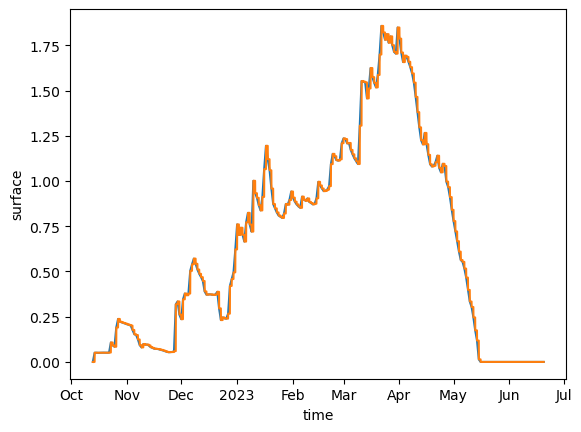

In [9]:
lidar_snowdepth_da = xr.open_dataset("~/Development/data/sublimationofsnow/lidar_snow_depth/D_from_D_l6.nc").resample(time = "1440Min").mean()['surface']
lidar_snowdepth_da = lidar_snowdepth_da.interpolate_na('time')
lidar_snowdepth_da = lidar_snowdepth_da.where(lidar_snowdepth_da > 0, 0)
lidar_snowdepth_upsample_da = lidar_snowdepth_da.resample(time = '30min').pad()
lidar_snowdepth_da.plot()
lidar_snowdepth_upsample_da.plot()
plt.show()

In [10]:
snowdepth_df = lidar_snowdepth_upsample_da.loc[
    sos_ds.time.min():sos_ds.time.max()
].to_dataframe()


# Option 2: Add as a variable
snowdepth_df = snowdepth_df.reset_index()
snowdepth_df = snowdepth_df[snowdepth_df.time.isin(sos_ds.time.values)]
snowdepth_df

,time,surface
0,2022-11-30 00:00:00,0.261997
1,2022-11-30 00:30:00,0.261997
2,2022-11-30 01:00:00,0.261997
3,2022-11-30 01:30:00,0.261997
4,2022-11-30 02:00:00,0.261997
...,...,...
7723,2023-05-09 21:30:00,0.398259
7724,2023-05-09 22:00:00,0.398259
7725,2023-05-09 22:30:00,0.398259
7726,2023-05-09 23:00:00,0.398259


In [11]:
sos_ds['SnowDepth_d'] = (['time'],  snowdepth_df.surface.values)

## Add/calculate longwave radiation and surface temperatures

In [12]:
sos_ds = variables.add_longwave_radiation(sos_ds)
sos_ds = variables.add_surface_temps(sos_ds)

### Clean $T_s$ variables before proceeding with other calculations

(as of Feb 20, 2023, using NCAR's QC data release, we found a single $T_s$ outlier.)

In [13]:
Tsurf_vars = [v for v in sos_ds.data_vars if v.startswith('Tsurf')]
Tsurf_vars

['Tsurf_rad_d',
 'Tsurf_c',
 'Tsurf_d',
 'Tsurf_ue',
 'Tsurf_uw',
 'Tsurfplanck_c',
 'Tsurfplanck_d',
 'Tsurfplanck_ue',
 'Tsurfplanck_uw']

In [14]:
for var in Tsurf_vars:
    print(sos_ds[var].max())
    print(sos_ds[var].min())

<xarray.DataArray 'Tsurf_rad_d' ()>
array(5.1737976, dtype=float32)
<xarray.DataArray 'Tsurf_rad_d' ()>
array(-30.22023, dtype=float32)
<xarray.DataArray 'Tsurf_c' ()>
array(1.9836426, dtype=float32)
<xarray.DataArray 'Tsurf_c' ()>
array(-78.6846, dtype=float32)
<xarray.DataArray 'Tsurf_d' ()>
array(222.1661, dtype=float32)
<xarray.DataArray 'Tsurf_d' ()>
array(-84.68779, dtype=float32)
<xarray.DataArray 'Tsurf_ue' ()>
array(2.2494812, dtype=float32)
<xarray.DataArray 'Tsurf_ue' ()>
array(-70.10573, dtype=float32)
<xarray.DataArray 'Tsurf_uw' ()>
array(2.1583862, dtype=float32)
<xarray.DataArray 'Tsurf_uw' ()>
array(-31.967834, dtype=float32)
<xarray.DataArray 'Tsurfplanck_c' ()>
array(1.7499695, dtype=float32)
<xarray.DataArray 'Tsurfplanck_c' ()>
array(-79.08504, dtype=float32)
<xarray.DataArray 'Tsurfplanck_d' ()>
array(223.18039, dtype=float32)
<xarray.DataArray 'Tsurfplanck_d' ()>
array(-85.093094, dtype=float32)
<xarray.DataArray 'Tsurfplanck_ue' ()>
array(2.016693, dtype=float32

In [15]:
for var in Tsurf_vars:
    sos_ds[var] = sos_ds[var].where(
        sos_ds[var].values < 40
    ).interpolate_na(
        dim='time', 
        method='linear'
    ).where(
        ~ sos_ds[var].isnull()
    )

In [16]:
for var in Tsurf_vars:
    print(sos_ds[var].max())
    print(sos_ds[var].min())

<xarray.DataArray 'Tsurf_rad_d' ()>
array(5.1737976, dtype=float32)
<xarray.DataArray 'Tsurf_rad_d' ()>
array(-30.22023, dtype=float32)
<xarray.DataArray 'Tsurf_c' ()>
array(1.9836426, dtype=float32)
<xarray.DataArray 'Tsurf_c' ()>
array(-78.6846, dtype=float32)
<xarray.DataArray 'Tsurf_d' ()>
array(1.9053345, dtype=float32)
<xarray.DataArray 'Tsurf_d' ()>
array(-84.68779, dtype=float32)
<xarray.DataArray 'Tsurf_ue' ()>
array(2.2494812, dtype=float32)
<xarray.DataArray 'Tsurf_ue' ()>
array(-70.10573, dtype=float32)
<xarray.DataArray 'Tsurf_uw' ()>
array(2.1583862, dtype=float32)
<xarray.DataArray 'Tsurf_uw' ()>
array(-31.967834, dtype=float32)
<xarray.DataArray 'Tsurfplanck_c' ()>
array(1.7499695, dtype=float32)
<xarray.DataArray 'Tsurfplanck_c' ()>
array(-79.08504, dtype=float32)
<xarray.DataArray 'Tsurfplanck_d' ()>
array(1.6714172, dtype=float32)
<xarray.DataArray 'Tsurfplanck_d' ()>
array(-85.093094, dtype=float32)
<xarray.DataArray 'Tsurfplanck_ue' ()>
array(2.016693, dtype=float3

## Add $T_v, \theta, \theta_v, \textbf{tke}, R_i, L$

In [17]:
sos_ds = variables.add_potential_virtual_temperatures(sos_ds)
sos_ds = variables.add_surface_potential_virtual_temperatures(sos_ds)
sos_ds = variables.add_tke(sos_ds)
sos_ds = variables.add_gradients_and_ri(sos_ds)
sos_ds = variables.add_shear_velocity_and_obukhov_length(sos_ds)

## Add decoupling metric, from Peltola et al. (2021).

We adjust the height value for snow depth.

In [18]:
def decoupling_metric(z, sigma_w, N):
    """Calculate the decoupling metric as described in Peltola et al (2021).

    Peltola, O., Lapo, K., & Thomas, C. K. (2021). A Physics‐Based Universal Indicator for Vertical Decoupling and Mixing Across Canopies Architectures and Dynamic Stabilities. Geophysical Research Letters, 48(5), e2020GL091615. https://doi.org/10.1029/2020GL091615
    
    Args:
        z (float): height of measurements 
        sigma_w (float): standarad deviation of w, vertical velocity
        N (float): Brunt-Vaisala frequency
    """
    # Brunt Vaisala frequency estimated using the bulk theta gradient
    # N = np.sqrt(
    #     g * (theta_e - theta_mean) / theta_mean
    # )

    Lb = sigma_w / N
    omega = Lb / ( np.sqrt(2)*z )
    return omega


In [19]:
#######################################################################
### OLD METHOD USING GRADIENT-BASED N
#######################################################################
from metpy.calc import brunt_vaisala_frequency

sigma_w = np.sqrt(sos_ds['w_w__3m_c']).values
pot_temps = sos_ds[[
    'Tpot_2m_c', 
    'Tpot_3m_c', 
    'Tpot_4m_c', 
    'Tpot_5m_c', 
    'Tpot_6m_c'
]].to_stacked_array(
    'z', ['time']
).values

snow_depth_values = sos_ds['SnowDepth_d']
snow_depth_values_reshaped = np.repeat(sos_ds['SnowDepth_d'].values, 5).reshape(-1, 5)

heights = np.full(pot_temps.shape,  [ 2,    3,    4,    5,    6])
heights_adjusted = heights - snow_depth_values_reshaped
brunt_vaisala_values = [ Ns[1] for Ns in 
    brunt_vaisala_frequency( 
        heights_adjusted * units("meters"),
        pot_temps * units("celsius"), 
        vertical_dim=1
    ).magnitude   
]
z = np.full(sigma_w.shape, 3) - snow_depth_values.values

# decoupling_metric(z, sigma_w, N)
print(len(z))
print(len(sigma_w))
print(len(brunt_vaisala_values))

omegas = decoupling_metric(z, sigma_w, brunt_vaisala_values)
sos_ds['omega_3m_c'] = (['time'],  omegas)
print(len(omegas))



#######################################################################
### NEW METHOD USING BULK N
#######################################################################
# sigma_w = np.sqrt(sos_ds['w_w__3m_c']).values

# snow_depth_values = sos_ds['SnowDepth_d'].values

# air_temp_height = 3
# heights_adjusted = air_temp_height - snow_depth_values
# surf_pottemp = sos_ds['Tsurfpot_c'].values
# air_pottemp = sos_ds['Tpot_3m_c'].values
# surfacealyer_avg_pottemp = 0.5*(air_pottemp + surf_pottemp)
# bulk_brunt_vaisala_value = np.sqrt(
#     metpy.constants.earth_gravity.magnitude.item()*(air_pottemp - surfacealyer_avg_pottemp) 
#     /
#     (surfacealyer_avg_pottemp * heights_adjusted)
# )
# z = np.full(sigma_w.shape, 3) - snow_depth_values

# # decoupling_metric(z, sigma_w, N)
# print(len(z))
# print(len(sigma_w))
# print(len(bulk_brunt_vaisala_value))

# omegas = decoupling_metric(z, sigma_w, bulk_brunt_vaisala_value)
# sos_ds['omega_3m_c'] = (['time'],  omegas)

7728
7728
7728
7728


/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_73063/56407381.py:16: RuntimeWarning: divide by zero encountered in divide
  Lb = sigma_w / N


(0.0, 1.0)

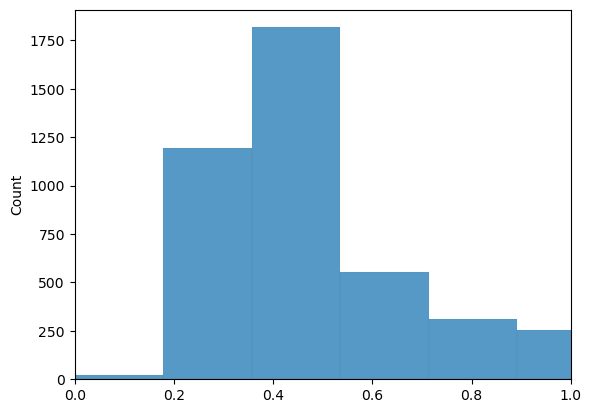

In [20]:
import seaborn as sns
sns.histplot(sos_ds['omega_3m_c'])
plt.xlim(0,1)

## Net LW and Net SW

In [21]:
sos_ds['Rlw_net_9m_d'] = sos_ds['Rlw_in_9m_d'] - sos_ds['Rlw_out_9m_d']
sos_ds['Rsw_net_9m_d'] = sos_ds['Rsw_in_9m_d'] - sos_ds['Rsw_out_9m_d']

## Net Radiation

In [23]:
sos_ds['Rnet_9m_d'] = (
    (sos_ds['Rsw_in_9m_d'] + sos_ds['Rlw_in_9m_d'])
    -
    (sos_ds['Rsw_out_9m_d'] + sos_ds['Rlw_out_9m_d'])
)

## Specific humidity

In [24]:
for var in [
    'Tsurfmixingratio_c',
    'mixingratio_2m_c',
    'mixingratio_3m_c',
    'mixingratio_4m_c',
    'mixingratio_5m_c',
    'mixingratio_6m_c',
    'mixingratio_7m_c',
    'mixingratio_8m_c',
    'mixingratio_9m_c',
    'mixingratio_10m_c',
    'mixingratio_11m_c',
    'mixingratio_12m_c',
    'mixingratio_13m_c',
    'mixingratio_14m_c',
    'mixingratio_15m_c',
    'mixingratio_16m_c',
    'mixingratio_17m_c',
    'mixingratio_18m_c',
    'mixingratio_19m_c',
    'mixingratio_20m_c',
]:
    new_var_name = var.replace('mixingratio', 'specifichumidity')
    sos_ds[new_var_name] = (['time'], specific_humidity_from_mixing_ratio(
        sos_ds[var]*units('g/g')
    ).values)

# Get Tidy Dataset

In [25]:
tidy_df = tidy.get_tidy_dataset(sos_ds, list(sos_ds.data_vars))

<Axes: xlabel='time'>

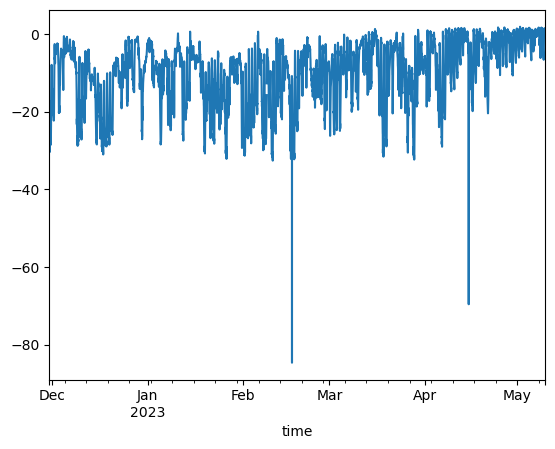

In [26]:
tidy_df.query("variable == 'Tsurf_d'").set_index('time')['value'].plot()

In [27]:
tidy_df.query("variable == 'u*_3m_c'").variable.unique()

array(['u*_3m_c'], dtype=object)

In [28]:
assert len(tidy_df.query("variable == 'omega_3m_c'")) > 0

Which variables did not get a "measurement" name assigned?

In [29]:
variables_with_no_measurement = tidy_df[tidy_df.measurement.apply(lambda x: x is None)].variable.unique()
variables_with_no_measurement

array(['Rpile_out_9m_d', 'Tcase_out_9m_d', 'Rpile_in_9m_d',
       'Tcase_in_9m_d', 'Tcase_uw', 'Rpile_in_uw', 'Rpile_out_uw',
       'Rnet_9m_d'], dtype=object)

In [30]:
set(tidy_df.variable.unique()).difference(set(list(sos_ds.data_vars)))

set()

# Model Estimates

## Penman-Monteith and Priestley-Taylor

### Gather the data we need

In [33]:
pyet_src = tidy_df[tidy_df.variable.isin([
    'Rnet_9m_d',
    'airdensity_3m_c',
    'Tsurfvaporpressure_c',
    'vaporpressure_3m_c',
    'T_3m_c',
    'spd_3m_c',
    'P_10m_c'
])].pivot_table(
    index=['time'],
    values='value',
    columns='variable'
# Calculate means across 30min periods, mins and maxes for the required variables too
).reset_index()
pyet_src.head(2)

variable,time,P_10m_c,Rnet_9m_d,T_3m_c,Tsurfvaporpressure_c,airdensity_3m_c,spd_3m_c,vaporpressure_3m_c
0,2022-11-30 00:00:00,713.159607,-55.816132,-12.797492,208.350677,0.954354,3.327945,150.922134
1,2022-11-30 00:30:00,713.428040,-78.091812,-13.050860,199.270233,0.955828,4.560800,114.408554


In [34]:
# From PyET code
# Equation for calculating the latent heat of vaporization from:
# Richard G Allen, Luis S Pereira, Dirk Raes, Martin Smith, and others. Crop evapotranspiration-Guidelines for computing crop 
# water requirements-FAO Irrigation and drainage paper 56. Fao, Rome, 300(9):D05109, 1998.
pyet_src['L_v estimated'] = 2.501 - 0.002361 * pyet_src['T_3m_c']

### Define function

In [35]:
import pyet

In [36]:
def calc_delta_alduchov(t_in_c):
# Taking the derivative of the Alduchov curve
# returns in kPa
    numerator = 37836.5*np.exp((22.587*t_in_c)/(273.86+t_in_c))
    denominator = (t_in_c + 273.86)**2
    # 0.1 to convert from millibars to kPa
    return 0.1*numerator/denominator

def calc_psychrometric_constant(C_p, P, L_v):
    # C_p in MJ/kg/˚C
    # P in kPa
    # L_v in MJ/kg
    # From wikipedia
    # https://en.wikipedia.org/wiki/Psychrometric_constant#cite_note-1
    # which cites this:
    #  Allen, R.G.; Pereira, L.S.; Raes, D.; Smith, M. (1998). Crop Evapotranspiration—Guidelines for Computing Crop Water Requirements. 
    # FAO Irrigation and drainage paper 56. Rome, Italy: Food and Agriculture Organization of the United Nations. ISBN 92-5-104219-5. Retrieved 2007-10-08.
    return C_p*P/(0.622 * L_v)

In [37]:
C_p = 1.013 * 10 ** -3  # MJ/kg/K

def penman_monteith(
    energy_available, # MJ/m^2/day
    density_air, # kg/m^3
    vapor_pressure_surface, # kPa
    vapor_pressure_air, # kPa
    temp_air, # ˚C
    pressure, # kPa
    wind_speed, # m/s
    L_v
):
    A = energy_available
    rho_a = density_air
    e_s = vapor_pressure_surface
    e_a = vapor_pressure_air
    
    # delta = pyet.calc_vpc(temp_air)
    delta = calc_delta_alduchov(temp_air)
    y = calc_psychrometric_constant(C_p, pressure, L_v)
    r_a = pyet.calc_res_aero(wind_speed) # I should replace this with some better method for estimating atmospheric resistance - i.e. see Mahrt and Vickers, 2005, i.e. r_a = 1/(wind_speed * C_q)
    r_s = 0

    numerator = delta*A + rho_a*86400*C_p*(e_s - e_a)/r_a
    denominator = delta + y*(1 + r_s / r_a)
    return (1/L_v)*(numerator/denominator)

### Do calculations

In [38]:
pyet_src['pm results'] = penman_monteith(
    (pyet_src['Rnet_9m_d'].to_xarray() * units("W/m^2")).pint.to("MJ/m^2/day").values,
    pyet_src['airdensity_3m_c'].values,
    (pyet_src['Tsurfvaporpressure_c'].to_xarray() * units("Pa")).pint.to("kPa").values,
    (pyet_src['vaporpressure_3m_c'].to_xarray() * units("Pa")).pint.to("kPa").values,
    pyet_src['T_3m_c'].values,
    (pyet_src['P_10m_c'].to_xarray() * units("millibars")).pint.to("kPa").values,
    pyet_src['spd_3m_c'].values,
    pyet_src['L_v estimated'].values
)

### Convert from mm/day to g/m^2/s

In [39]:
pyet_src['pm results'] = pyet_src['pm results']/(86.4)

<Axes: xlabel='time'>

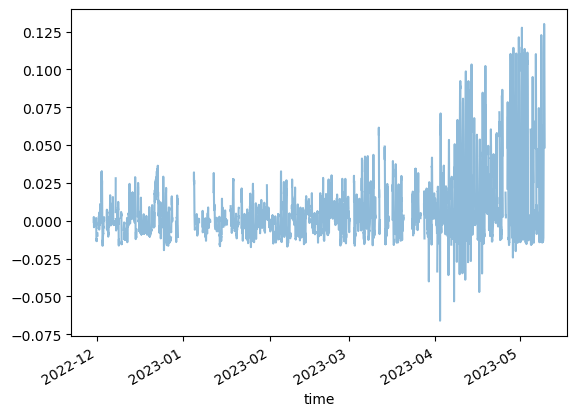

In [40]:
pyet_src.set_index('time')['pm results'].plot(alpha=0.5)

<Axes: xlabel='time'>

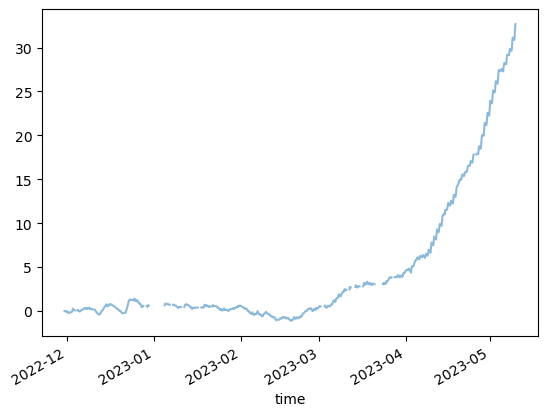

In [41]:
pyet_src.set_index('time')['pm results'].cumsum().plot(alpha=0.5)

### Add to tidy df

Fill missing timestamps with NaNs

In [42]:
pm_values = tidy_df.query("variable == 'spd_3m_c'").merge(
    pyet_src[['time', 'pm results']],
    on='time',
    how='left'
)['pm results'].values

In [43]:
tidy_df = tidy.tidy_df_add_variable(
    tidy_df,
    pm_values,
    f'w_h2o__3m_c predicted (Penman Monteith)',
    'w_h2o_',
    3,
    'c'
)

## MOST (my iterative solution, in most.py)

Prepare the input data we need

In [44]:
# EXTRACT VARIABLES
VARIABLES = [
    ## Input Variables
    'spd_3m_c',
    'Tpot_3m_c',
    'Tsurfpot_c',
    'airdensity_3m_c',
    'mixingratio_3m_c',
    'Tsurfmixingratio_c',
    'T_3m_c',
    ## Measurement Variables
    'w_h2o__3m_c',
    'w_tc__3m_c',
    'u*_3m_c',
    'Ri_3m_c',
]
print([ v for v in tidy_df.variable.unique() if v in VARIABLES ])

# CREATE WIDE DATAFRAME
variables_df = tidy_df[tidy_df.variable.isin(VARIABLES)].pivot_table(
    values = 'value',
    index = 'time',
    columns='variable'
).reset_index()

# MAKE CONVERSIONS
# convert from ˚C to K
variables_df['T_3m_c'] = variables_df['T_3m_c'] + 273.15
variables_df['Tpot_3m_c'] = variables_df['Tpot_3m_c'] + 273.15
variables_df['Tsurfpot_c'] = variables_df['Tsurfpot_c'] + 273.15
# comes in units of g/g
variables_df['specifichumidity_3m_c'] = specific_humidity_from_mixing_ratio(
    xr.DataArray(variables_df['mixingratio_3m_c'])*units('g/g')
).pint.to('g/kg').values
# comes in units of g/g,  solution requires it in units of g/kg
variables_df['specifichumidity_surface_c'] = specific_humidity_from_mixing_ratio(
    xr.DataArray(variables_df['Tsurfmixingratio_c'])*units('g/g')
).pint.to('g/kg').values



# CREATE MEASUREMENT HEIGHT VARIABLES
variables_df['measurement_height'] = 3

['w_tc__3m_c', 'w_h2o__3m_c', 'spd_3m_c', 'T_3m_c', 'Tpot_3m_c', 'airdensity_3m_c', 'mixingratio_3m_c', 'Tsurfmixingratio_c', 'Tsurfpot_c', 'Ri_3m_c', 'u*_3m_c']


In [45]:
import sys
sys.path.append('../paper1/')
from most import MOST, StabilityFunctionBrutsaert1982

most_config_dict = {
    0.00001: MOST(StabilityFunctionBrutsaert1982(), snow_surface_roughness = 0.00001),
    0.00005: MOST(StabilityFunctionBrutsaert1982(), snow_surface_roughness = 0.00005),
    0.0001: MOST(StabilityFunctionBrutsaert1982(), snow_surface_roughness = 0.0001),
    0.0005: MOST(StabilityFunctionBrutsaert1982(), snow_surface_roughness = 0.0005),
    0.001: MOST(StabilityFunctionBrutsaert1982(), snow_surface_roughness = 0.001),
    0.005: MOST(StabilityFunctionBrutsaert1982(), snow_surface_roughness = 0.005),
}

for z0, this_most in most_config_dict.items():
    L_solutions, u_friction_solutions, H_solutions, E_solutions = this_most.solve(
        variables_df['spd_3m_c'],
        variables_df['Tpot_3m_c'],
        variables_df['Tsurfpot_c'],
        variables_df['airdensity_3m_c'],
        variables_df['specifichumidity_3m_c'],
        variables_df['specifichumidity_surface_c'],
        variables_df['T_3m_c'],
        variables_df['measurement_height']
    )

    variables_df[f'L_solution_z0_{str(z0)}'] = L_solutions
    variables_df[f'u_friction_solution_z0_{str(z0)}'] = u_friction_solutions
    variables_df[f'H_solution_z0_{str(z0)}'] = H_solutions
    variables_df[f'E_solution_z0_{str(z0)}'] = E_solutions

    # convert from W/m^2 to ˚C*m/s
    variables_df[f'H_solution_z0_{str(z0)}'] = (variables_df[f'H_solution_z0_{str(z0)}']/(variables_df['airdensity_3m_c']*0.718*1000))

Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
R

Add nans for the model results where there are missing timesteps (As compared to the tidy dataset of measurements)

In [46]:
variables_df['time'] = pd.to_datetime(variables_df['time'])

variables_df = pd.merge(
    tidy_df.query("variable == 'w_h2o__3m_c'")[['time']],
    variables_df,
    on='time',
    how='outer'
)

### Add to tidy df

In [47]:
# OUR SOLUTIONS
for z0 in most_config_dict.keys():
    tidy_df = tidy.tidy_df_add_variable(
        tidy_df,  
        variables_df[f'L_solution_z0_{z0}'], 
        f'L predicted ({z0})',
        'Obukhov length', 
        3,
        'c'
    )

    tidy_df = tidy.tidy_df_add_variable(
        tidy_df, 
        variables_df[f'u_friction_solution_z0_{z0}'], 
        f'u*_3m_c predicted ({z0})',
        'shear velocity', 
        3,
        'c'
    )

    tidy_df = tidy.tidy_df_add_variable(
        tidy_df, 
        variables_df[f'H_solution_z0_{z0}'], 
        f'w_tc__3m_c predicted ({z0})',
        'w_tc_', 
        3,
        'c'
    )

    tidy_df = tidy.tidy_df_add_variable(
        tidy_df, 
        variables_df[f'E_solution_z0_{z0}'], 
        f'w_h2o__3m_c predicted ({z0})',
        'w_h2o_', 
        3,
        'c'
    )

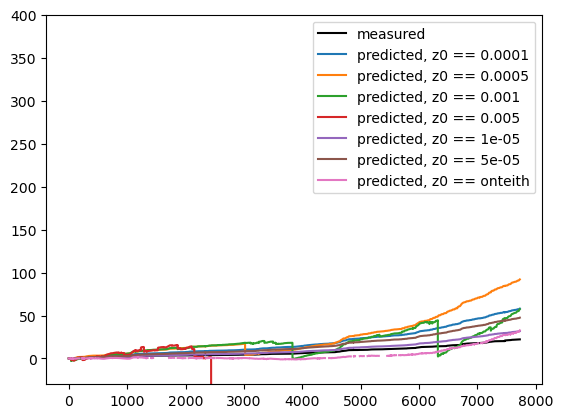

In [48]:
src = tidy_df[tidy_df.measurement == 'w_h2o_'].pivot_table(
    values = 'value',
    index = 'time',
    columns='variable'
).reset_index()


src['w_h2o__5m_c'].cumsum().plot(color='black', label='measured')
for col in [c for c in src.columns if 'predicted' in c]:
    src[col].cumsum().plot(label = f"predicted, z0 == {col.split(' ')[-1][1:-1]}")
plt.ylim(-30,400)
plt.legend()

# Save dataset

In [53]:
ls -lah | grep parquet

-rw-r--r--    1 elischwat  staff    30M Feb 20 22:08 coare_model_results.parquet
-rw-r--r--    1 elischwat  staff    53M Feb 21 06:17 model_results.parquet
-rw-r--r--    1 elischwat  staff   112M Feb 13 11:16 model_results_archive.parquet
-rw-r--r--    1 elischwat  staff    32M Feb 21 16:15 tidy_df_20221130_20230509_noplanar_fit.parquet
-rw-r--r--    1 elischwat  staff   257M Feb 20 22:02 tidy_df_20221130_20230509_noplanar_fit_ARCHIVE.parquet
-rw-r--r--    1 elischwat  staff   263M Feb 20 22:02 tidy_df_20221130_20230509_noplanar_fit_clean.parquet
-rw-r--r--    1 elischwat  staff    46M Feb 20 22:03 tidy_df_30min_20221130_20230509_noplanar_fit_clean.parquet


In [52]:
if PLANAR_FIT:    
    tidy_df.to_parquet(f'tidy_df_{start_date}_{end_date}_planar_fit.parquet', index=False)
else:
    tidy_df.to_parquet(f'tidy_df_{start_date}_{end_date}_noplanar_fit.parquet', index=False)

In [54]:
ls -lah | grep parquet

-rw-r--r--    1 elischwat  staff    30M Feb 20 22:08 coare_model_results.parquet
-rw-r--r--    1 elischwat  staff    53M Feb 21 06:17 model_results.parquet
-rw-r--r--    1 elischwat  staff   112M Feb 13 11:16 model_results_archive.parquet
-rw-r--r--    1 elischwat  staff    32M Feb 21 16:15 tidy_df_20221130_20230509_noplanar_fit.parquet
-rw-r--r--    1 elischwat  staff   257M Feb 20 22:02 tidy_df_20221130_20230509_noplanar_fit_ARCHIVE.parquet
-rw-r--r--    1 elischwat  staff   263M Feb 20 22:02 tidy_df_20221130_20230509_noplanar_fit_clean.parquet
-rw-r--r--    1 elischwat  staff    46M Feb 20 22:03 tidy_df_30min_20221130_20230509_noplanar_fit_clean.parquet
